## Chanuka Clustering

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib_venn import venn3
import numpy as np
# to view all columns in a dataframe
pd.set_option('display.max_columns', None)

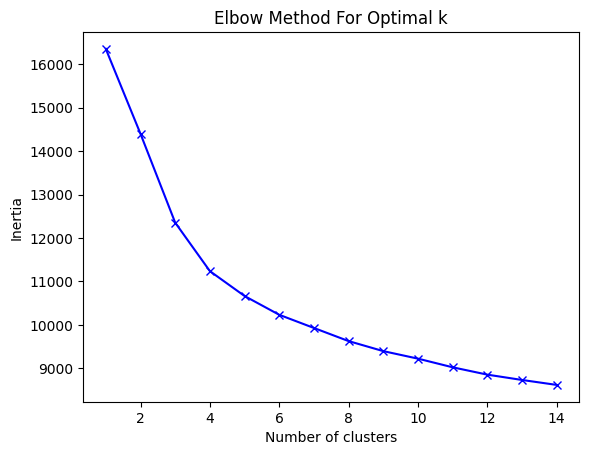

Text(0, 0.5, 'Principal Component 2')

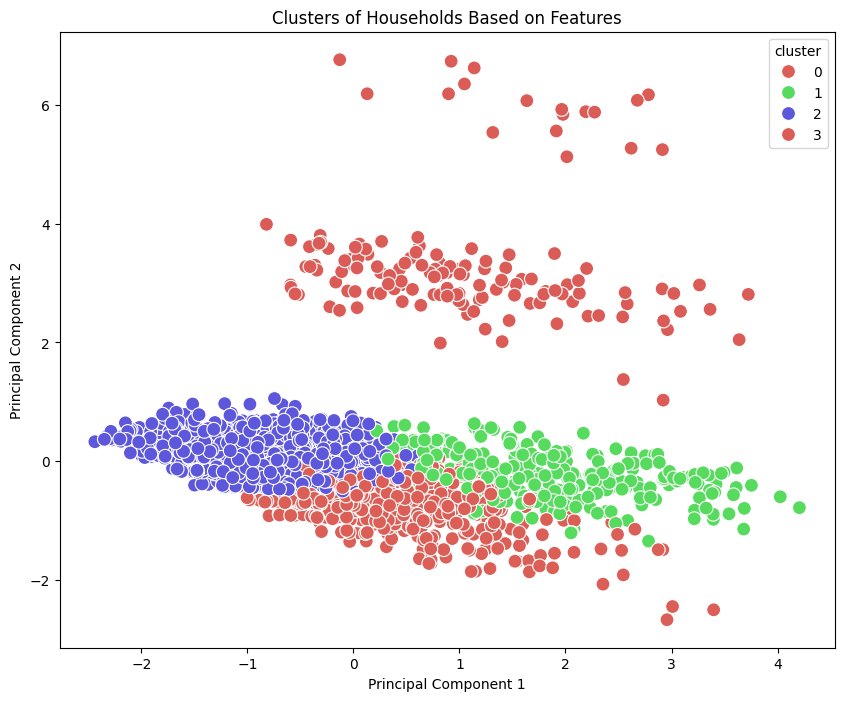

In [12]:
data_survey = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_household_information_and_history.csv')
generation = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_electricity_generation_water_heating_cooking.csv')
generation.fillna({'solar_system_ongrid_or_offgird': 'No'}, inplace=True)

data_survey = data_survey.merge(generation[['household_ID', 'solar_system_ongrid_or_offgird']], on='household_ID', how='left')

data = data_survey[['household_ID', 'is_there_business_carried_out_in_the_household',
             'total_monthly_expenditure_of_last_month',
             'no_of_household_members',
             'type_of_electricity_meter',
             'socio_economic_class',
             'occupy_renters_boarders',
             'no_of_electricity_meters',
             'type_of_house',
             'main_material_used_for_walls_of_the_house',
             'main_material_used_for_roof_of_the_house',
             'built_year_of_the_house', 'solar_system_ongrid_or_offgird']].copy()

data.dropna(inplace=True)

household_ids = data['household_ID'].copy()
data.drop(columns=['household_ID'], inplace=True)

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(data[categorical_cols])

scaler = StandardScaler()
X_num = scaler.fit_transform(data[numerical_cols])
X = np.hstack([X_num, X_cat])

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

data['household_ID'] = household_ids.values  # re-add ID
data['cluster'] = clusters

inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Visualizing clusters using principle component analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['cluster'], palette='hls', s=100)
plt.title('Clusters of Households Based on Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [13]:
# categorical summary and numerical summary
num_summary = data.groupby('cluster')[numerical_cols].mean().round(2)
cat_summary = data.groupby('cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

# filtering for houses having smart meters
data_sm = data[data['type_of_electricity_meter'] == 'Smart meter'].copy()

In [15]:
nsm = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/monthly_consumption.csv')
nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')
# Filtering smart meter data from anomolous very low and very high values
nsm = nsm[(nsm['consumption'] > 20) & (nsm['consumption'] < 10000)]
nsm_avg = nsm.groupby('household_ID')['consumption'].mean().reset_index()
data = data.merge(nsm_avg, on='household_ID', how='right')

data_cluster_groups = data.groupby('cluster')['consumption'].agg(['mean', 'std']).reset_index()

In [16]:
'''
# Option 1: IQR

def label_outliers(group):
    Q1 = group['consumption'].quantile(0.25)
    Q3 = group['consumption'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 0.75 * IQR
    group['high_consumption_outlier'] = (group['consumption'] > upper_bound).astype(int)
    return group


data = data.groupby('cluster').apply(label_outliers)
data1 = data[data['high_consumption_outlier'] == 1]
data1.to_csv('inefficient_households_cluster.csv', index=False)

'''
# 0ption 2

data = data.merge(data_cluster_groups, on='cluster', how='left')
data['inefficient'] = data['consumption'] > (data['mean'] + 0.3 * data['std'])

ineff = data[data['inefficient'] == True].copy()
ineff = ineff[['household_ID', 'cluster', 'consumption', 'mean', 'std']].copy()
ineff.to_csv('inefficient_households_cluster.csv', index=False)  


'''
# 0ption 3: Z-score

from scipy.stats import zscore

def label_outliers_z(group):
    group['z'] = zscore(group['consumption'])
    group['high_consumption_outlier'] = (group['z'] > 2).astype(int)  # You can adjust threshold
    return group

data = data.groupby('cluster').apply(label_outliers_z)
data1 = data[data['high_consumption_outlier'] == 1]
data1.to_csv('inefficient_households_cluster.csv', index=False)

'''

"\n# 0ption 3: Z-score\n\nfrom scipy.stats import zscore\n\ndef label_outliers_z(group):\n    group['z'] = zscore(group['consumption'])\n    group['high_consumption_outlier'] = (group['z'] > 2).astype(int)  # You can adjust threshold\n    return group\n\ndata = data.groupby('cluster').apply(label_outliers_z)\ndata1 = data[data['high_consumption_outlier'] == 1]\ndata1.to_csv('inefficient_households_cluster.csv', index=False)\n\n"

In [17]:
ineff.columns

Index(['household_ID', 'cluster', 'consumption', 'mean', 'std'], dtype='object')

In [18]:
# Get household_IDs from ineff dataframe
ineff_household_ids = set(ineff['household_ID'])
print(f"Number of household_IDs in ineff: {len(ineff_household_ids)}")

# Directory containing the 6hour interval CSV files
csv_directory = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'

# Get all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]
print(f"CSV files found: {csv_files}")

# Collect all household_IDs from all CSV files
csv_household_ids = set()

for csv_file in csv_files:
    file_path = os.path.join(csv_directory, csv_file)
    print(f"Processing {csv_file}...")
    
    try:
        # Read only the first few rows to check structure
        sample_df = pd.read_csv(file_path, nrows=5)
        print(f"Columns in {csv_file}: {list(sample_df.columns)}")
        
        # Check if household_ID column exists (or similar column)
        household_col = None
        for col in sample_df.columns:
            if 'household' in col.lower() or 'id' in col.lower():
                household_col = col
                break
        
        if household_col:
            # Read only the household_ID column to save memory
            df_ids = pd.read_csv(file_path, usecols=[household_col])
            file_household_ids = set(df_ids[household_col].dropna().astype(str))
            csv_household_ids.update(file_household_ids)
            print(f"Found {len(file_household_ids)} unique household_IDs in {csv_file}")
        else:
            print(f"No household_ID column found in {csv_file}")
            
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

print(f"\nTotal unique household_IDs across all CSV files: {len(csv_household_ids)}")

Number of household_IDs in ineff: 520
CSV files found: ['smart_6hour_1.csv', 'smart_6hour_4.csv', 'smart_6hour_3.csv', 'smart_6hour_2.csv', 'smart_6hour_5.csv']
Processing smart_6hour_1.csv...
Columns in smart_6hour_1.csv: ['household_ID', 'BRANCH', 'DEPOT', 'substation_ID', 'SUB_TYPE', 'E_BILLING', 'EXPORT', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)', 'TOTAL_IMPORT - PV1 (kWh)', 'TOTAL_EXPORT - PV1 (kWh)', 'TR1_TOTAL_IMPORT (kWh)', 'TR2_TOTAL_IMPORT (kWh)', 'TR3_TOTAL_IMPORT (kWh)', 'TR1_TOTAL_EXPORT (kWh)', 'TR2_TOTAL_EXPORT (kWh)', 'TR3_TOTAL_EXPORT (kWh)', 'TR1_TOTAL_IMPORT - PV1 (kWh)', 'TR2_TOTAL_IMPORT - PV1 (kWh)', 'TR3_TOTAL_IMPORT - PV1 (kWh)', 'TR1_TOTAL_EXPORT - PV1 (kWh)', 'TR2_TOTAL_EXPORT - PV1 (kWh)', 'TR3_TOTAL_EXPORT - PV1 (kWh)', 'PHASE_A_CURRENT (A)', 'PHASE_A_VOLTAGE (V)', 'FREQUENCY (Hz)', 'PHASE_B_CURRENT (A)', 'PHASE_B_VOLTAGE (V)', 'PHASE_C_CURRENT (A)', 'PHASE_C_VOLTAGE (V)']
Found 2813 unique household_IDs in smart_6hour_1.csv
Processing smart

In [19]:
# Find household_IDs that are in both ineff and CSV files
common_household_ids = ineff_household_ids.intersection(csv_household_ids)

print(f"Household_IDs in ineff: {len(ineff_household_ids)}")
print(f"Household_IDs in CSV files: {len(csv_household_ids)}")
print(f"Common household_IDs: {len(common_household_ids)}")

# Convert to list for easier handling
common_household_ids_list = list(common_household_ids)

# Display first 10 common household_IDs
print(f"\nFirst 10 common household_IDs:")
for i, hid in enumerate(common_household_ids_list[:10]):
    print(f"{i+1}. {hid}")

# Save the common household_IDs to a CSV file
common_ids_df = pd.DataFrame({'household_ID': common_household_ids_list})
output_file = 'common_household_ids_ineff_and_6hour.csv'
common_ids_df.to_csv(output_file, index=False)
print(f"\nCommon household_IDs saved to: {output_file}")

Household_IDs in ineff: 520
Household_IDs in CSV files: 2950
Common household_IDs: 182

First 10 common household_IDs:
1. ID1992
2. ID0634
3. ID2263
4. ID2344
5. ID1381
6. ID0857
7. ID2636
8. ID1794
9. ID1847
10. ID2133

Common household_IDs saved to: common_household_ids_ineff_and_6hour.csv


In [20]:
# Optional: Create a detailed analysis
print("=== DETAILED ANALYSIS ===")
print(f"Household_IDs only in ineff (not in CSV files): {len(ineff_household_ids - csv_household_ids)}")
print(f"Household_IDs only in CSV files (not in ineff): {len(csv_household_ids - ineff_household_ids)}")

# Show some examples of IDs only in ineff
only_in_ineff = ineff_household_ids - csv_household_ids
if only_in_ineff:
    print(f"\nFirst 5 household_IDs only in ineff:")
    for i, hid in enumerate(list(only_in_ineff)[:5]):
        print(f"{i+1}. {hid}")

# Show some examples of IDs only in CSV files
only_in_csv = csv_household_ids - ineff_household_ids
if only_in_csv:
    print(f"\nFirst 5 household_IDs only in CSV files:")
    for i, hid in enumerate(list(only_in_csv)[:5]):
        print(f"{i+1}. {hid}")

=== DETAILED ANALYSIS ===
Household_IDs only in ineff (not in CSV files): 338
Household_IDs only in CSV files (not in ineff): 2768

First 5 household_IDs only in ineff:
1. ID2368
2. ID0278
3. ID0034
4. ID0470
5. ID2450

First 5 household_IDs only in CSV files:
1. ID2874
2. ID4616
3. ID5208
4. ID3353
5. ID3365


## Comparison with Autoencoder Outliers

In [21]:
# Load the datasets for Venn diagram analysis
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

# Load common household IDs (inefficient + 6hour interval)
common_ids_df = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/common_household_ids_ineff_and_6hour.csv')
common_household_ids_set = set(common_ids_df['household_ID'].astype(str))

# Load anomalous households from autoencoder (all SEC classes combined)
anomalous_sec_a = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/anomalous_households_autoencoder_SEC_A.csv')
anomalous_sec_b = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/anomalous_households_autoencoder_SEC_B.csv')
anomalous_sec_c = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/anomalous_households_autoencoder_SEC_C.csv')

# Combine all anomalous households
all_anomalous = pd.concat([anomalous_sec_a, anomalous_sec_b, anomalous_sec_c], ignore_index=True)
anomalous_household_ids_set = set(all_anomalous['household_ID'].astype(str))

print(f"Common household IDs (inefficient + 6hour): {len(common_household_ids_set)}")
print(f"Anomalous household IDs (autoencoder): {len(anomalous_household_ids_set)}")

# Calculate intersection
intersection = common_household_ids_set.intersection(anomalous_household_ids_set)
print(f"Intersection: {len(intersection)}")

Common household IDs (inefficient + 6hour): 182
Anomalous household IDs (autoencoder): 288
Intersection: 45


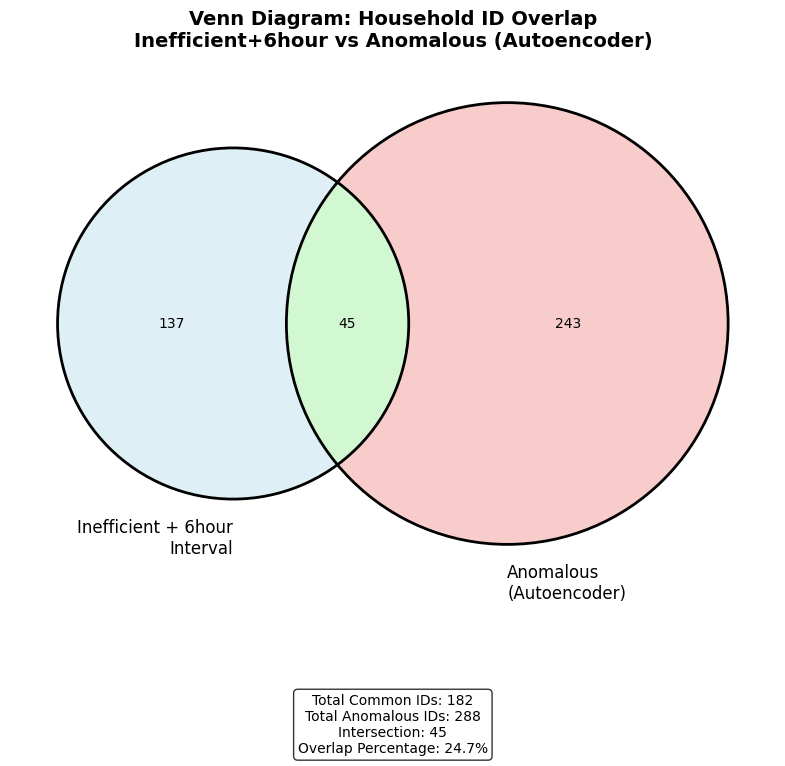

In [22]:
# Create the total Venn diagram
plt.figure(figsize=(12, 8))

# Create Venn diagram
venn = venn2([common_household_ids_set, anomalous_household_ids_set], 
             set_labels=('Inefficient + 6hour\nInterval', 'Anomalous\n(Autoencoder)'))

# Customize the diagram
venn.get_patch_by_id('10').set_color('lightblue')
venn.get_patch_by_id('01').set_color('lightcoral')
venn.get_patch_by_id('11').set_color('lightgreen')

# Add circles for better visualization
venn2_circles([common_household_ids_set, anomalous_household_ids_set])

plt.title('Venn Diagram: Household ID Overlap\nInefficient+6hour vs Anomalous (Autoencoder)', 
          fontsize=14, fontweight='bold')

# Add text with statistics
plt.text(0.5, -0.3, f'Total Common IDs: {len(common_household_ids_set)}\n' +
                    f'Total Anomalous IDs: {len(anomalous_household_ids_set)}\n' +
                    f'Intersection: {len(intersection)}\n' +
                    f'Overlap Percentage: {len(intersection)/min(len(common_household_ids_set), len(anomalous_household_ids_set))*100:.1f}%',
         transform=plt.gca().transAxes, ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [25]:
# Debug: Let's first understand the data better
print("=== DEBUGGING INFORMATION ===")
print(f"Total intersection from overall analysis: {len(intersection)}")
print(f"Common household IDs: {len(common_household_ids_set)}")
print(f"Anomalous household IDs: {len(anomalous_household_ids_set)}")

# Check the socio-economic class distribution in our datasets
print("\n--- Socio-economic class distribution in data ---")
if 'socio_economic_class' in data.columns:
    print(data['socio_economic_class'].value_counts())
else:
    print("No socio_economic_class column found in data")

# Check the merge results
common_with_sec = common_ids_df.merge(data[['household_ID', 'socio_economic_class']], 
                                     on='household_ID', how='left')
print(f"\n--- Common IDs after merging with SEC info ---")
print(f"Total common IDs with SEC info: {len(common_with_sec)}")
print(f"Common IDs with non-null SEC: {common_with_sec['socio_economic_class'].notna().sum()}")
if 'socio_economic_class' in common_with_sec.columns:
    print("SEC distribution in common IDs:")
    print(common_with_sec['socio_economic_class'].value_counts(dropna=False))

# Check SEC distribution in anomalous data
print(f"\n--- SEC distribution in anomalous data ---")
print(f"SEC A anomalous households: {len(anomalous_sec_a)}")
print(f"SEC B anomalous households: {len(anomalous_sec_b)}")
print(f"SEC C anomalous households: {len(anomalous_sec_c)}")
print(f"Total: {len(anomalous_sec_a) + len(anomalous_sec_b) + len(anomalous_sec_c)}")

=== DEBUGGING INFORMATION ===
Total intersection from overall analysis: 45
Common household IDs: 182
Anomalous household IDs: 288

--- Socio-economic class distribution in data ---
socio_economic_class
SEC C    781
SEC B    490
SEC A    422
SEC D    418
SEC E    159
Name: count, dtype: int64

--- Common IDs after merging with SEC info ---
Total common IDs with SEC info: 182
Common IDs with non-null SEC: 182
SEC distribution in common IDs:
socio_economic_class
SEC A    67
SEC C    48
SEC B    48
SEC D    12
SEC E     7
Name: count, dtype: int64

--- SEC distribution in anomalous data ---
SEC A anomalous households: 136
SEC B anomalous households: 98
SEC C anomalous households: 54
Total: 288


In [26]:
# Let's manually check the intersection for each SEC class
print("=== MANUAL INTERSECTION CALCULATION ===")

# For each SEC class, find the intersection
manual_intersections = {}
total_manual_intersection = 0

for sec_class, sec_df in zip(['SEC A', 'SEC B', 'SEC C'], [anomalous_sec_a, anomalous_sec_b, anomalous_sec_c]):
    # Get anomalous household IDs for this SEC class
    anomalous_sec_ids = set(sec_df['household_ID'].astype(str))
    
    # Find intersection with ALL common household IDs (not filtered by SEC)
    sec_intersection = common_household_ids_set.intersection(anomalous_sec_ids)
    manual_intersections[sec_class] = sec_intersection
    
    print(f"{sec_class}: {len(sec_intersection)} intersections")
    print(f"  Sample IDs: {list(sec_intersection)[:5]}")
    
    total_manual_intersection += len(sec_intersection)

print(f"\nSum of manual intersections: {total_manual_intersection}")
print(f"Original total intersection: {len(intersection)}")

# Check if there are any overlaps between SEC classes (which shouldn't exist)
sec_a_ids = set(anomalous_sec_a['household_ID'].astype(str))
sec_b_ids = set(anomalous_sec_b['household_ID'].astype(str))
sec_c_ids = set(anomalous_sec_c['household_ID'].astype(str))

print(f"\n--- Checking for overlaps between SEC classes ---")
print(f"SEC A ∩ SEC B: {len(sec_a_ids.intersection(sec_b_ids))}")
print(f"SEC A ∩ SEC C: {len(sec_a_ids.intersection(sec_c_ids))}")
print(f"SEC B ∩ SEC C: {len(sec_b_ids.intersection(sec_c_ids))}")

# Verify total unique anomalous IDs
all_unique_anomalous = sec_a_ids.union(sec_b_ids).union(sec_c_ids)
print(f"\nTotal unique anomalous IDs across all SEC: {len(all_unique_anomalous)}")
print(f"Should match anomalous_household_ids_set: {len(anomalous_household_ids_set)}")

=== MANUAL INTERSECTION CALCULATION ===
SEC A: 31 intersections
  Sample IDs: ['ID1992', 'ID2221', 'ID0457', 'ID2223', 'ID0596']
SEC B: 9 intersections
  Sample IDs: ['ID1381', 'ID1144', 'ID2483', 'ID1132', 'ID1854']
SEC C: 5 intersections
  Sample IDs: ['ID1074', 'ID1488', 'ID1721', 'ID0499', 'ID2766']

Sum of manual intersections: 45
Original total intersection: 45

--- Checking for overlaps between SEC classes ---
SEC A ∩ SEC B: 0
SEC A ∩ SEC C: 0
SEC B ∩ SEC C: 0

Total unique anomalous IDs across all SEC: 288
Should match anomalous_household_ids_set: 288


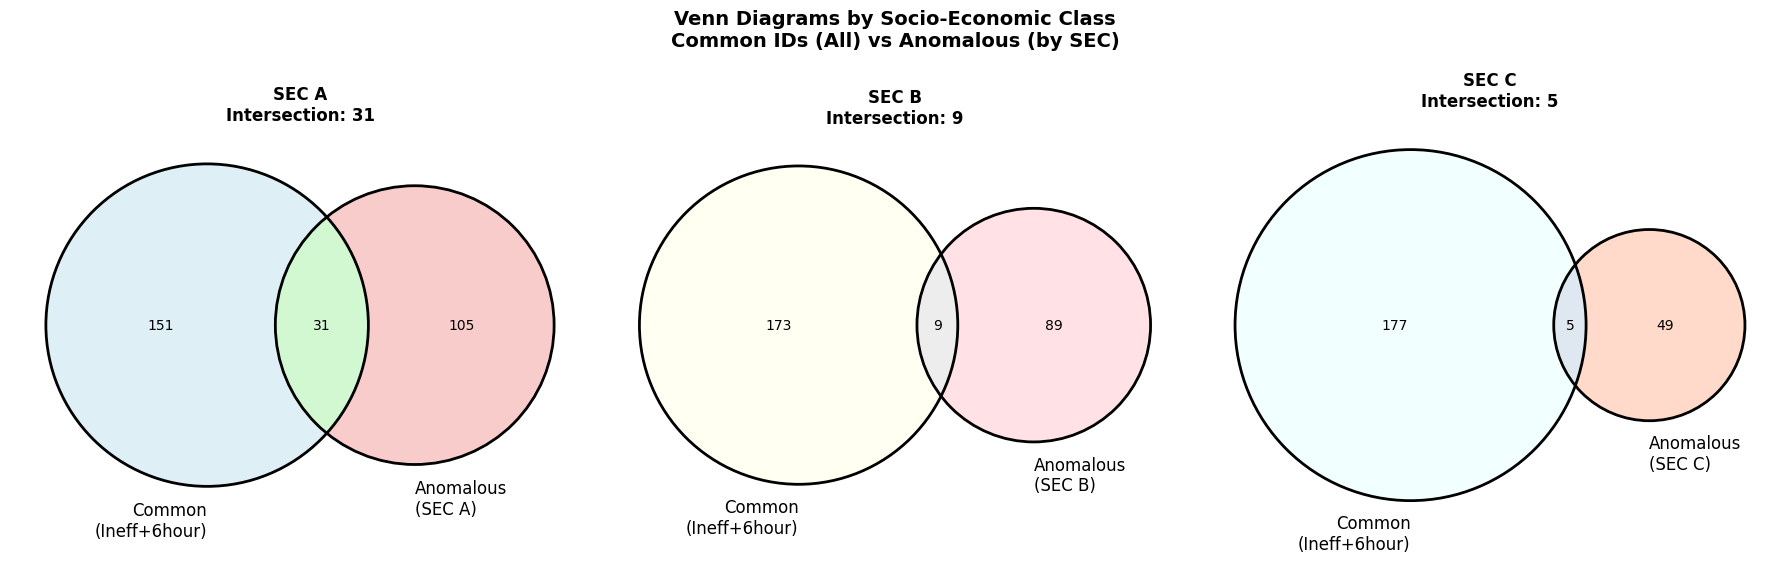


Verification:
Sum of SEC intersections: 45
Original total intersection: 45
Match: True


In [27]:
# Fixed Socio-economic class wise Venn diagrams
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sec_classes = ['SEC A', 'SEC B', 'SEC C']
sec_dataframes = [anomalous_sec_a, anomalous_sec_b, anomalous_sec_c]
colors = [('lightblue', 'lightcoral', 'lightgreen'), 
          ('lightyellow', 'lightpink', 'lightgray'),
          ('lightcyan', 'lightsalmon', 'lightsteelblue')]

# Create Venn diagrams using the manual intersection approach
for i, (sec_class, sec_df, color_set) in enumerate(zip(sec_classes, sec_dataframes, colors)):
    
    # Get anomalous household IDs for this SEC class
    anomalous_sec_ids = set(sec_df['household_ID'].astype(str))
    
    # Use ALL common household IDs (not filtered by SEC class)
    # The intersection will show which common IDs are also anomalous in this SEC
    common_sec_ids = common_household_ids_set
    
    # Create Venn diagram for this SEC class
    ax = axes[i]
    plt.sca(ax)
    
    if len(common_sec_ids) > 0 and len(anomalous_sec_ids) > 0:
        venn = venn2([common_sec_ids, anomalous_sec_ids], 
                     set_labels=('Common\n(Ineff+6hour)', f'Anomalous\n({sec_class})'))
        
        # Color the patches
        if venn.get_patch_by_id('10'):
            venn.get_patch_by_id('10').set_color(color_set[0])
        if venn.get_patch_by_id('01'):
            venn.get_patch_by_id('01').set_color(color_set[1])
        if venn.get_patch_by_id('11'):
            venn.get_patch_by_id('11').set_color(color_set[2])
        
        # Add circles
        venn2_circles([common_sec_ids, anomalous_sec_ids])
        
        # Calculate intersection
        sec_intersection = common_sec_ids.intersection(anomalous_sec_ids)
        
        ax.set_title(f'{sec_class}\nIntersection: {len(sec_intersection)}', 
                    fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'{sec_class}\nNo data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{sec_class}', fontsize=12, fontweight='bold')

plt.suptitle('Venn Diagrams by Socio-Economic Class\nCommon IDs (All) vs Anomalous (by SEC)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Verify the sum
total_sec_intersections = sum([len(common_household_ids_set.intersection(set(df['household_ID'].astype(str)))) for df in sec_dataframes])
print(f"\nVerification:")
print(f"Sum of SEC intersections: {total_sec_intersections}")
print(f"Original total intersection: {len(intersection)}")
print(f"Match: {total_sec_intersections == len(intersection)}")

In [28]:
# Alternative approach: Show SEC class distribution within the intersection
print("=== ALTERNATIVE ANALYSIS: SEC Distribution in Intersection ===")

# Get the actual intersection household IDs
intersection_ids = list(intersection)
intersection_df = pd.DataFrame({'household_ID': intersection_ids})

# Try to get SEC information for intersection IDs from multiple sources
# Source 1: From the original data
intersection_with_data_sec = intersection_df.merge(data[['household_ID', 'socio_economic_class']], 
                                                  on='household_ID', how='left')

# Source 2: From the anomalous data itself
intersection_with_anomalous_sec = intersection_df.copy()
intersection_with_anomalous_sec['SEC_from_anomalous'] = None

for idx, row in intersection_with_anomalous_sec.iterrows():
    hid = str(row['household_ID'])
    if hid in set(anomalous_sec_a['household_ID'].astype(str)):
        intersection_with_anomalous_sec.at[idx, 'SEC_from_anomalous'] = 'SEC A'
    elif hid in set(anomalous_sec_b['household_ID'].astype(str)):
        intersection_with_anomalous_sec.at[idx, 'SEC_from_anomalous'] = 'SEC B'
    elif hid in set(anomalous_sec_c['household_ID'].astype(str)):
        intersection_with_anomalous_sec.at[idx, 'SEC_from_anomalous'] = 'SEC C'

print("SEC distribution in intersection (from original data):")
if 'socio_economic_class' in intersection_with_data_sec.columns:
    print(intersection_with_data_sec['socio_economic_class'].value_counts(dropna=False))

print("\nSEC distribution in intersection (from anomalous data):")
print(intersection_with_anomalous_sec['SEC_from_anomalous'].value_counts(dropna=False))

# Save detailed intersection analysis
detailed_intersection = intersection_df.merge(intersection_with_data_sec[['household_ID', 'socio_economic_class']], 
                                            on='household_ID', how='left')
detailed_intersection = detailed_intersection.merge(intersection_with_anomalous_sec[['household_ID', 'SEC_from_anomalous']], 
                                                  on='household_ID', how='left')

detailed_intersection.to_csv('detailed_intersection_analysis.csv', index=False)
print(f"\nDetailed intersection analysis saved to: detailed_intersection_analysis.csv")

=== ALTERNATIVE ANALYSIS: SEC Distribution in Intersection ===
SEC distribution in intersection (from original data):
socio_economic_class
SEC A    22
SEC B     9
SEC C     9
SEC D     4
SEC E     1
Name: count, dtype: int64

SEC distribution in intersection (from anomalous data):
SEC_from_anomalous
SEC A    31
SEC B     9
SEC C     5
Name: count, dtype: int64

Detailed intersection analysis saved to: detailed_intersection_analysis.csv
